In [1]:

from dotenv import load_dotenv
load_dotenv()
import scllm as sl
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI

# Factor analysis

## PBMC dataset


In this tutorial we leverage `scllm` to annotate the PCA factors with cell type annotations.

In [2]:
pbmc = sc.datasets.pbmc3k_processed()

In [3]:
openai_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=openai_model)

In [7]:
sl.tl.annotate_factor(pbmc, 'PCs', llm, factors=['0', '1', '2', '3'], top_genes=40, key_added='pca_annotation')

In [8]:
pbmc.uns['pca_annotation']


[{'factor': '0', 'sign': '+', 'cell_type': 'CD8+ T cell'},
 {'factor': '0', 'sign': '-', 'cell_type': 'Monocyte/Macrophage'},
 {'factor': '1', 'sign': '+', 'cell_type': 'B cell'},
 {'factor': '1', 'sign': '-', 'cell_type': 'Cytotoxic T cell'},
 {'factor': '2', 'sign': '+', 'cell_type': 'B cell'},
 {'factor': '2', 'sign': '-', 'cell_type': 'Platelet'},
 {'factor': '3', 'sign': '+', 'cell_type': 'T cell'},
 {'factor': '3', 'sign': '-', 'cell_type': 'B cell'}]

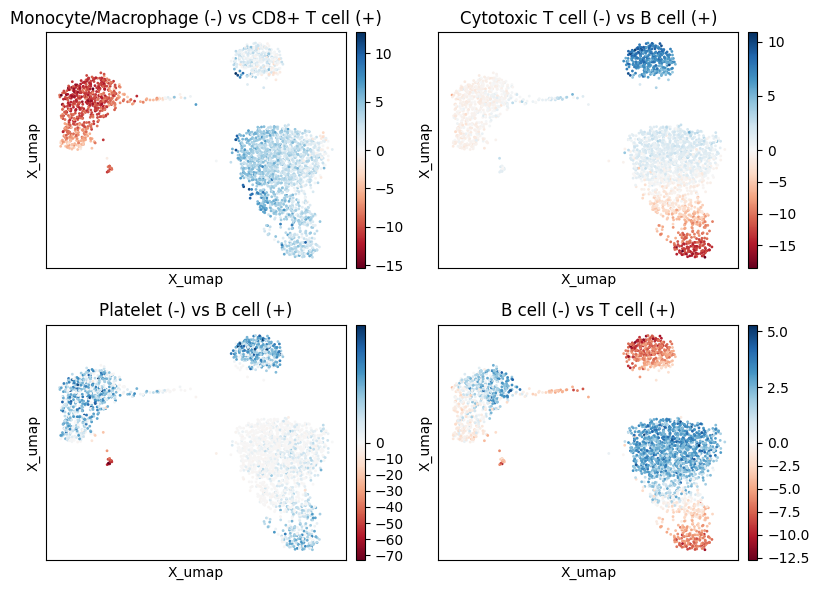

In [9]:
_ = sl.pl.factor_embedding(
    pbmc, 
    'pca', 
    factors=['0', '1', '2', '3'], 
    basis='X_umap', 
    annotation='pca_annotation',
    ncols=2
    )
plt.tight_layout()

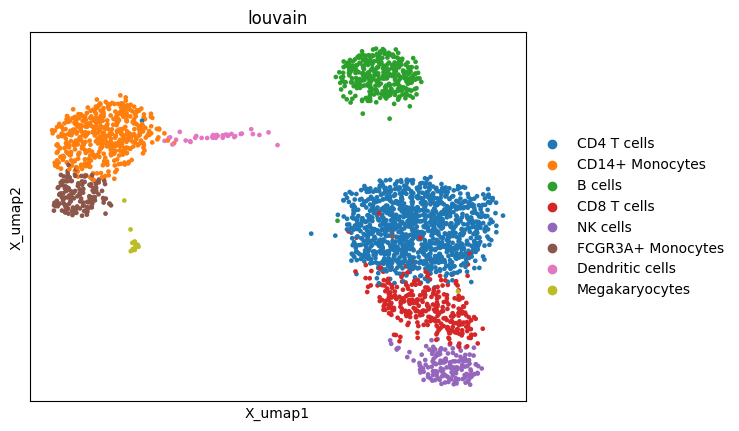

In [18]:
sc.pl.embedding(pbmc, 'X_umap', color='louvain')

## Angelidis

In this example we will use the `annotate_cluster` function to annotate the cells in the Angelidis dataset.

In [10]:
angelidis = sc.read_h5ad('/Users/harald/Downloads/umap_1.h5ad')

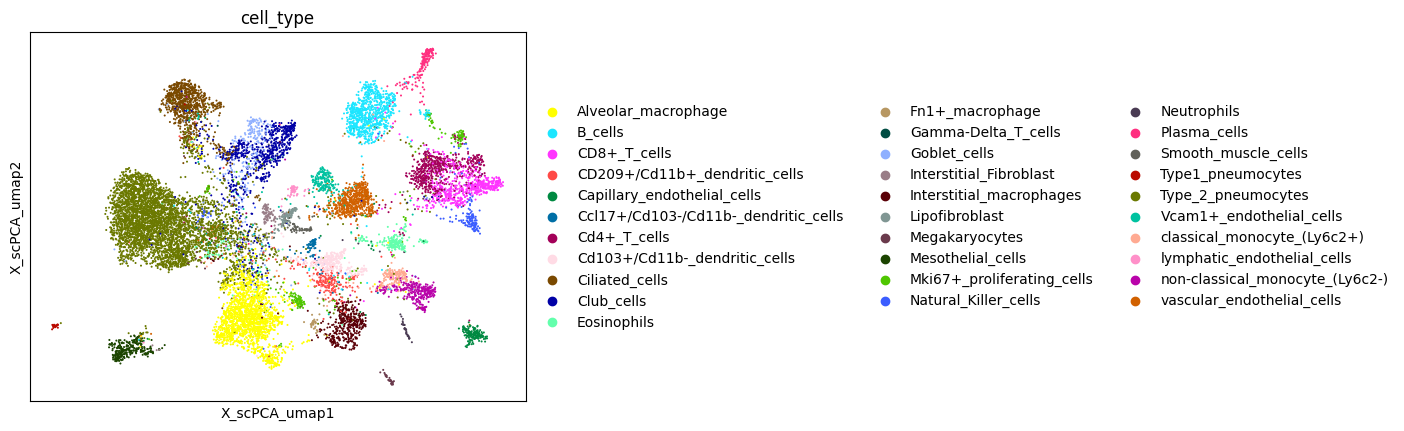

In [11]:
sc.pl.embedding(angelidis, 'X_scPCA_umap', color='cell_type')

In [26]:
angelidis

AnnData object with n_obs × n_vars = 14064 × 4000
    obs: 'barcode', 'mouse_id', 'age', 'cell_type', 'cell_id', 'super'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'X_scPCA', 'celltype_column', 'condition_column', 'hvg', 'log1p', 'main_assay', 'scPCA', 'umap', 'cell_type_colors', 'pca_annotation', 'scpca_annotation'
    obsm: 'X_scPCA', 'X_scPCA_umap'
    varm: 'V_scPCA', 'W_scPCA', 'α_scPCA', 'σ_scPCA', 'W_scpca_ref'
    layers: 'counts', 'offset_scPCA', 'μ_scPCA'
    obsp: 'X_scPCA_connectivities', 'X_scPCA_distances'

In [16]:
angelidis.varm['W_scpca_ref'] = angelidis.varm['W_scPCA'][..., 0]

In [22]:
sl.tl.annotate_factor(
    angelidis, 
    'W_scpca_ref', 
    llm,
    factors=['0', '1', '2', '3', '4', '5', '6'], 
    top_genes=40, 
    key_added='scpca_annotation'
)

In [25]:
angelidis.uns['scpca_annotation']

[{'factor': '0', 'sign': '+', 'cell_type': 'Macrophage'},
 {'factor': '0', 'sign': '-', 'cell_type': 'Ciliated Epithelial Cell'},
 {'factor': '1', 'sign': '+', 'cell_type': 'Alveolar Type II Cells'},
 {'factor': '1', 'sign': '-', 'cell_type': 'B cell'},
 {'factor': '2', 'sign': '+', 'cell_type': 'B cell'},
 {'factor': '2', 'sign': '-', 'cell_type': 'Club Cells'},
 {'factor': '3', 'sign': '+', 'cell_type': 'Endothelial cells'},
 {'factor': '3', 'sign': '-', 'cell_type': 'B cell'},
 {'factor': '4', 'sign': '+', 'cell_type': 'B cell'},
 {'factor': '4', 'sign': '-', 'cell_type': 'Macrophage'},
 {'factor': '5', 'sign': '+', 'cell_type': 'Ciliated Epithelial Cell'},
 {'factor': '5', 'sign': '-', 'cell_type': 'Endothelial Cell'},
 {'factor': '6', 'sign': '+', 'cell_type': 'Dendritic Cell'},
 {'factor': '6', 'sign': '-', 'cell_type': 'CD8+ T cell'}]

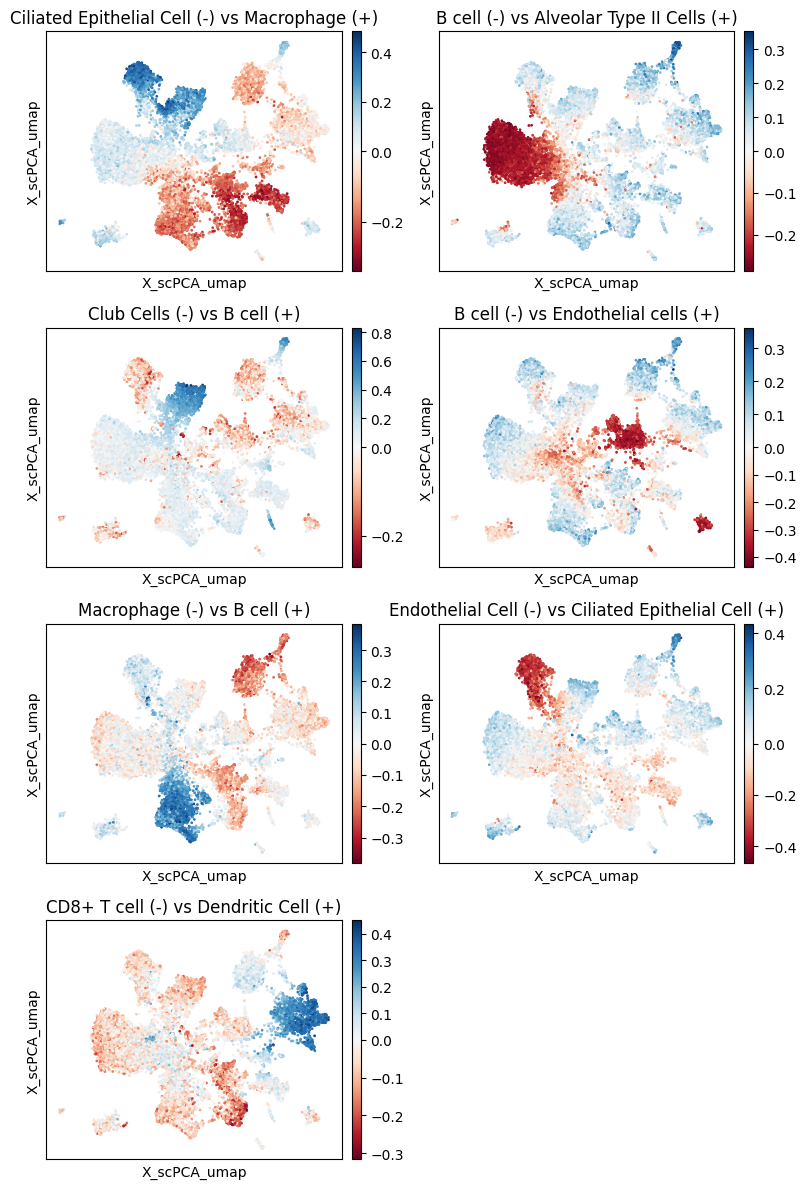

In [29]:
_ = sl.pl.factor_embedding(
    angelidis, 
    'scPCA', 
    factors=['0', '1', '2', '3', '4', '5', '6'], 
    basis='X_scPCA_umap', 
    annotation='scpca_annotation',
    ncols=2
    )
plt.tight_layout()

In [27]:
angelidis.layers['log1p'] = sc.pp.log1p(angelidis.layers['counts'])

In [28]:
sl.tl.annotate_cluster(angelidis, 'leiden', llm, top_genes=30, num_samples=20, layer='log1p', method='wilcoxon')

/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/harald/Documents/opt/scllm/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.

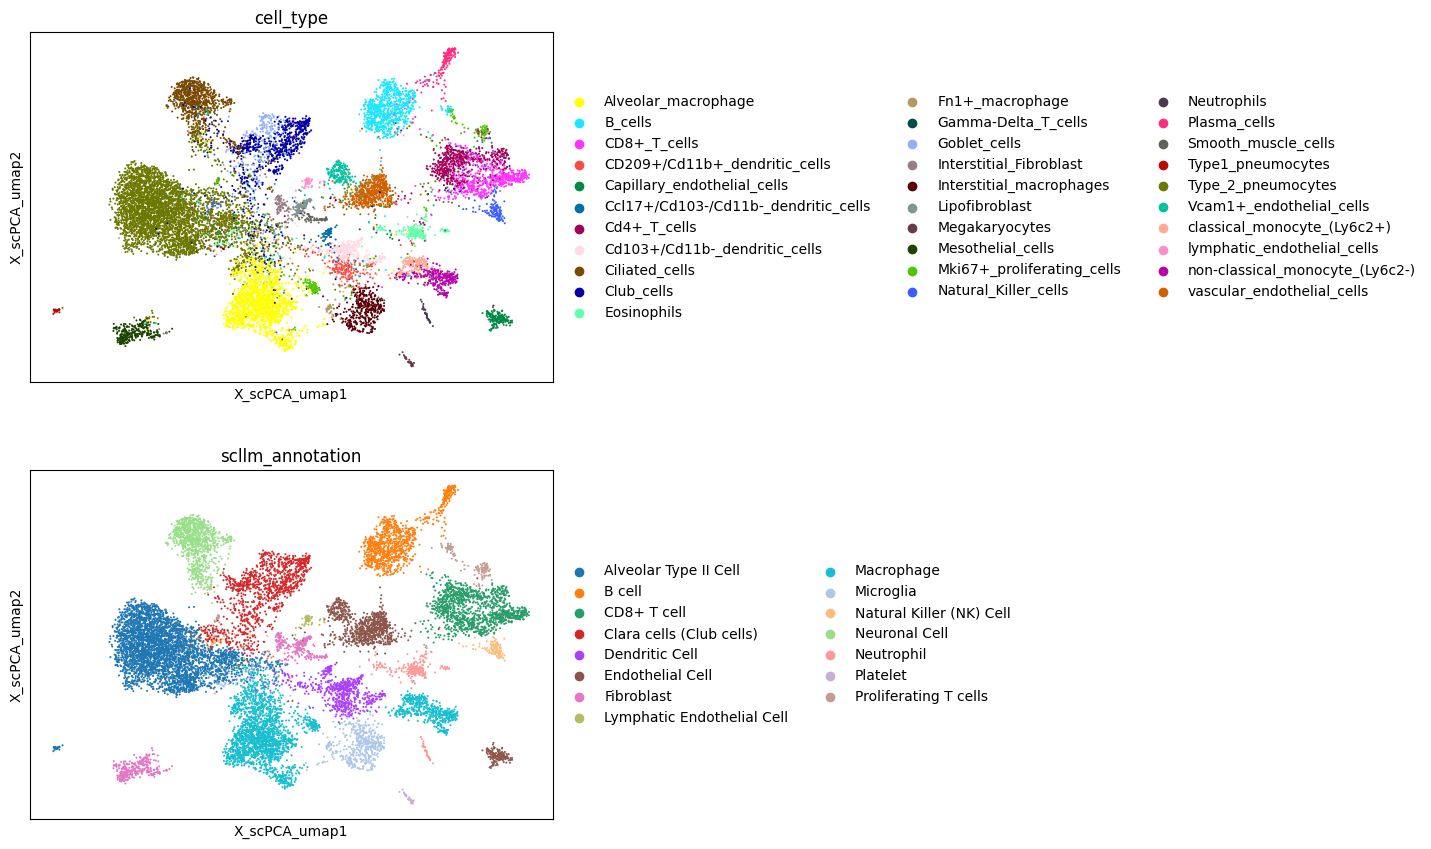

In [35]:
sc.pl.embedding(angelidis, basis='X_scPCA_umap', color=['cell_type', 'scllm_annotation'], ncols=1)